In [1]:
!pip install aiohttp bs4 matplotlib numpy

  Using cached aiohttp-3.8.1-cp37-cp37m-macosx_10_9_x86_64.whl (570 kB)
  Using cached bs4-0.0.1-py3-none-any.whl
  Using cached matplotlib-3.5.1-cp37-cp37m-macosx_10_9_x86_64.whl (7.3 MB)
  Using cached numpy-1.21.5-cp37-cp37m-macosx_10_9_x86_64.whl (16.9 MB)
  Using cached multidict-6.0.2-cp37-cp37m-macosx_10_9_x86_64.whl (28 kB)
  Using cached charset_normalizer-2.0.12-py3-none-any.whl (39 kB)
  Using cached yarl-1.7.2-cp37-cp37m-macosx_10_9_x86_64.whl (120 kB)
  Using cached aiosignal-1.2.0-py3-none-any.whl (8.2 kB)
  Using cached asynctest-0.13.0-py3-none-any.whl (26 kB)
  Using cached frozenlist-1.3.0-cp37-cp37m-macosx_10_9_x86_64.whl (35 kB)
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
  Using cached idna-3.3-py3-none-any.whl (61 kB)
  Using cached beautifulsoup4-4.10.0-py3-none-any.whl (97 kB)
  Using cached kiwisolver-1.3.2-cp37-cp37m-macosx_10_9_x86_64.whl (61 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached Pillow-9.0.1-cp37-cp37m-mac

In [7]:
from datetime import datetime

from bs4 import BeautifulSoup
import aiohttp
from aiohttp.client_exceptions import (
    ServerDisconnectedError,
    ClientConnectionError
)
import asyncio
from functools import wraps
import logging
import re
import itertools
from typing import Iterable, Dict
from urllib.parse import urljoin

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class ServerError(Exception):
    pass


class ITMOScrapper:
    BASE_URL = "https://itmo.ru/"
    PERSONALII_POSTFIX = "/ru/personlist/personalii.htm"

    ACADEMIC_DEGREE = "ученая степень:"
    ACADEMIC_POSITION = "должность:"

    RETRY_NUMBER = 20

    def __init__(self, session: aiohttp.ClientSession):
        self._session = session

    def _retry(func):
        @wraps(func)
        async def wrapper(self, *args, **kwargs):
            for retry_id in range(ITMOScrapper.RETRY_NUMBER):
                try:
                    result = await func(self, *args, **kwargs)
                except (
                        ServerDisconnectedError,
                        ServerError,
                        ClientConnectionError,
                ) as e:
                    if retry_id == ITMOScrapper.RETRY_NUMBER - 1:
                        raise e

                    logger.warning(
                        f"Retry request with arguments {args}, {kwargs}"
                    )
                else:
                    return result

        return wrapper

    async def _do_request2(self, postfix: str) -> str:
        url = urljoin(self.BASE_URL, postfix)
        async with self._session.get(url) as resp:
            text = await resp.text()
            return text

    async def _do_request(self, postfix: str) -> str:
        url = urljoin(self.BASE_URL, postfix)
        async with aiohttp.ClientSession() as session:
            async with session.get(url) as resp:
                text = await resp.text()
                return text

    @_retry
    async def fetch_letter_urls(self) -> Iterable[str]:
        text = await self._do_request(self.PERSONALII_POSTFIX)
        soup = BeautifulSoup(text, features="html.parser")
        objs = soup.select(".b-page-nav li a")
        links = (obj.get("href") for obj in objs)
        return links

    async def fetch_all_teachers(self, urls) -> Iterable[str]:
        results = await asyncio.gather(*[
            self.fetch_teachers_by_url(url) for url in urls
        ])

        urls = set()
        for result in results:
            urls.update(result)

        return urls

    @_retry
    async def fetch_teachers_by_url(self, url) -> Iterable[str]:
        text = await self._do_request(url)
        soup = BeautifulSoup(text, features="html.parser")

        if not soup.find():
            raise ServerError("Server error")

        objs = soup.select(".main-content .phoneList article a")
        links = list(obj.get("href") for obj in objs)

        return links

    async def fetch_all_teachers_details(self, urls):
        return list(await asyncio.gather(*[
            self.fetch_teacher_details(url) for url in urls
        ]))

    @_retry
    async def fetch_teacher_details(self, url) -> Dict[str, any]:
        text = await self._do_request(url)

        soup = BeautifulSoup(text, features="html.parser")
        if not soup.find():
            raise ServerError("Server error")

        degrees = await self._get_academic_degrees(soup)

        positions = await self._get_academic_positions(soup)

        publications_number = await self._get_publications_number(soup)

        return {
            "url": url,
            "degrees": degrees,
            "positions": positions,
            "publications_number": publications_number,
        }

    async def _get_academic_degrees(
            self, soup: BeautifulSoup,
    ) -> Iterable[str]:
        info = soup.select(".c-personCard-details dl")[0]

        degrees = []
        for line in info:
            if line.text.strip().lower() == self.ACADEMIC_DEGREE:
                degree = line.findNext("dd").text.strip().lower()
                degrees.append(re.sub(" +", " ", degree))

        return degrees

    async def _get_academic_positions(
            self, soup: BeautifulSoup,
    ) -> Iterable[str]:
        info = soup.select(".c-personCard-details dl")[1]

        positions = []

        for line in info:
            if line.text.strip().lower() == self.ACADEMIC_POSITION:
                cur_position = []
                for inner_line in line.findNext("dd").contents:
                    if inner_line.name == "br":
                        positions.append(" ".join(cur_position))
                        cur_position = []
                        continue

                    cur_position.append(inner_line.text.strip())

                if cur_position:
                    positions.append(" ".join(cur_position))

        return positions

    async def _get_publications_number(self, soup: BeautifulSoup) -> int:
        info = soup.select_one(".nav-tabs a:contains(Публикации) .badge")
        return int(info.text) if info else 0


session = None
scrapper = ITMOScrapper(session)
letter_urls = list(await scrapper.fetch_letter_urls())
logger.info(f"Letters: {len(letter_urls)}")

teachers_urls = list(await scrapper.fetch_all_teachers(letter_urls))
logger.info(f"Teachers number: {len(teachers_urls)}")

users = await scrapper.fetch_all_teachers_details(teachers_urls)

INFO:__main__:Letters: 28
INFO:__main__:Teachers number: 892


In [8]:
logger.info('1. Employees with multiple positions:')
logger.info(len([
    user['url'] for user in users if len(user['positions']) >= 2
]))

INFO:__main__:1. Employees with multiple positions:
INFO:__main__:394


In [9]:
logger.info('2. Maximum number of positions for an employee:')
logger.info(max(len(user["positions"]) for user in users))


INFO:__main__:2. Maximum number of positions for an employee:
INFO:__main__:6


In [11]:
logger.info('3. Number of employees with academic degrees:')
logger.info(sum(1 for user in users if user['degrees']))


INFO:__main__:3. Number of employees with academic degrees:
INFO:__main__:435


In [12]:
logger.info('4. Academic degrees:')
logger.info(len(set(itertools.chain(*(user['degrees'] for user in users)))))

INFO:__main__:4. Academic degrees:
INFO:__main__:27


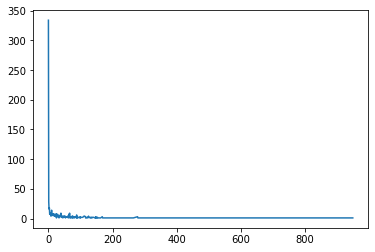

In [13]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

counter = Counter(user['publications_number'] for user in users)
x, y = np.hsplit(np.array(sorted(list(counter.items()), key=lambda x: x[0])), 2)

plt.plot(x, y)
plt.show()

In [15]:
logger.info('6. Average publications number')
with_degree = sum(1 for user in users if user['degrees'])
publications_number_with_degr = sum(
    user['publications_number']
    for user in users
    if user['degrees']
)
without_degree = sum(1 for user in users if not user['degrees'])
publications_number_without_degr = sum(
    user['publications_number']
    for user in users
    if not user['degrees']
)
avg_with_degr = publications_number_with_degr / with_degree
avg_without_degr = publications_number_without_degr / without_degree

logger.info(f'With a scientific degree: {avg_with_degr}')
logger.info(f'Without a scientific degree: {avg_without_degr}')

INFO:__main__:6. Average publications number
INFO:__main__:With a scientific degree: 82.19770114942528
INFO:__main__:Without a scientific degree: 5.671772428884026
